# Full Technical Report Section

In [42]:
# First we download the data

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1UJVoJqzHc7DZC8YDCN8e15LA6DvEnsuY' -O X.txt
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=15HONyJXWARLhNAtNQXFWAH8pvGPahh_U' -O y.txt

--2022-03-25 11:19:21--  https://docs.google.com/uc?export=download&id=1UJVoJqzHc7DZC8YDCN8e15LA6DvEnsuY
Resolving docs.google.com (docs.google.com)... 142.250.178.14, 216.239.32.10, 216.239.34.10, ...
Connecting to docs.google.com (docs.google.com)|142.250.178.14|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-88-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bl5qlen84lgif27gs0fkkbtcpup31610/1648207125000/03911252296720181638/*/1UJVoJqzHc7DZC8YDCN8e15LA6DvEnsuY?e=download [following]
--2022-03-25 11:19:22--  https://doc-0c-88-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bl5qlen84lgif27gs0fkkbtcpup31610/1648207125000/03911252296720181638/*/1UJVoJqzHc7DZC8YDCN8e15LA6DvEnsuY?e=download
Resolving doc-0c-88-docs.googleusercontent.com (doc-0c-88-docs.googleusercontent.com)... 142.250.200.1, 216.239.32.10, 216.239.34.10, ...
Connecting to doc-0c-88-docs.googleusercontent.com (doc-0c-88-d

In [43]:
import numpy as np
import scipy
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

plt.style.use('ggplot')

X = np.loadtxt('X.txt')
y = np.loadtxt('y.txt')

### Functions given to us or adapated by me in the regular coursework exercise:

Not my code!!! (except for a line here and there)

In [44]:
def split_data(X, y, frac=0.8):

    # We randomly permute the data
    permutation = np.random.permutation(X.shape[ 0 ])
    X = X[ permutation, : ]
    y = y[ permutation ]

    n_train = int(frac*X.shape[0])
    X_train = X[ 0 : n_train, : ]
    X_test = X[ n_train :, : ]
    y_train = y[ 0 : n_train ]
    y_test = y[ n_train : ]
    return X_train, X_test, y_train, y_test

def get_x_tilde(X): 
    return np.concatenate((np.ones((X.shape[ 0 ], 1 )), X), 1)

def logistic(x): 
    return 1.0 / (1.0 + np.exp(-x))

def predict(X_tilde, w): 
    return logistic(np.dot(X_tilde, w))

def plot_data_internal(X, y):
    x_min, x_max = X[ :, 0 ].min() - .5, X[ :, 0 ].max() + .5
    y_min, y_max = X[ :, 1 ].min() - .5, X[ :, 1 ].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    plt.figure()
    plt.xlim(xx.min(None), xx.max(None))
    plt.ylim(yy.min(None), yy.max(None))
    ax = plt.gca()
    ax.plot(X[y == 0, 0], X[y == 0, 1], 'ro', label = 'Class 1')
    ax.plot(X[y == 1, 0], X[y == 1, 1], 'bo', label = 'Class 2')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Plot data')
    plt.legend(loc = 'upper left', scatterpoints = 1, numpoints = 1)
    return xx, yy

def plot_data(X, y):
    xx, yy = plot_data_internal(X, y)
    plt.show()

def average_map_ll(X_tilde, y, w_map):
    output_prob = predict(X_tilde, w_map)
    BtX = np.dot(X_tilde, w_map)
    return np.mean(y * np.where(BtX < -10, BtX, np.log(output_prob)) + (1 - y) * np.log(1.0 - output_prob))

def evaluate_basis_functions(l, X, Z):
    X2 = np.sum(X**2, 1)
    Z2 = np.sum(Z**2, 1)
    ones_Z = np.ones(Z.shape[ 0 ])
    ones_X = np.ones(X.shape[ 0 ])
    r2 = np.outer(X2, ones_Z) - 2 * np.dot(X, Z.T) + np.outer(ones_X, Z2)
    return np.exp(-0.5 / l**2 * r2)

def plot_predictive_distribution(X, y, w, map_inputs = lambda x : x):
    xx, yy = plot_data_internal(X, y)
    ax = plt.gca()
    X_tilde = get_x_tilde(map_inputs(np.concatenate((xx.ravel().reshape((-1, 1)), yy.ravel().reshape((-1, 1))), 1)))
    Z = predict(X_tilde, w)
    Z = Z.reshape(xx.shape)
    cs2 = ax.contour(xx, yy, Z, cmap='RdBu', linewidths = 2, levels=[0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95])
    cs3 = ax.contour(xx, yy, Z, colors='k', linewidths = 3, levels=[0.5])
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize = 14)
    plt.clabel(cs3, fmt = '%2.1f', colors = 'k', fontsize = 14)
    plt.show()

### Functions written by me:

In [45]:
def neg_lpd(w, X_tilde, y, S, m_0):
    """
    - Function that computes the negative log (l) of the posterior (p) distribution (d) under the Laplace approximation
    - Returns a scalar
    """
    preds = predict(X_tilde, w)
    ll = np.sum(y*np.log(preds) + (1-y)*np.log(1-preds))
    log_prior = - np.dot(np.dot(w-m_0, np.linalg.inv(S)), w-m_0)/2
    return - (ll + log_prior)

def neg_lpd_gradient(w, X_tilde, y, S, m_0):
    """
    - Function that computes the negative gradient of the log of the posterior distribution under the Laplace approximation
    - Assumes symmetric prior covariance matrix
    - Returns a vector
    """
    ll_grad = sum((y - predict(X_tilde, w)).reshape(-1, 1) * X_tilde)
    log_prior_grad = - np.dot(np.linalg.inv(S), w) + np.dot(np.linalg.inv(S), m_0)
    return - (ll_grad + log_prior_grad)

def hessian_ll(X_tilde, w, y, S_0):
    """
    - Function that computes the hessian of the log-likelihood, which is needed 
    to compute the covariance matrix for the posterior Gaussian distribution
    - Returns a matrix
    """
    preds = predict(X_tilde, w)
    inv_S = np.zeros((X_tilde.shape[1], X_tilde.shape[1]))

    for i in range(y.shape[0]):
        inv_S += preds[i]*(1-preds[i])*np.outer(X_tilde[i], X_tilde[i])
    return np.linalg.inv(np.linalg.inv(S_0) + np.sum(preds*(1-preds)))

def laplace_approx(X_tilde, y, sigma=1):
    """
    - Function that computes the posterior distribution under the Laplace approximation
    - The modal set of weights, w_map, are chosen by minimising the negative of (maximising)
    the log posterior distribution, while the covariance is found by inverting the negative 
    hessian of the log-likelihood
    - Returns the MAP weights, covariance matrix, and log of the model evidence
    """
    m_0 = np.zeros(X_tilde.shape[1])
    S_0 = (sigma**2) * np.identity(X_tilde.shape[1]) # prior covariance matrix, identity * sigma

    w_map, fmin, d = scipy.optimize.fmin_l_bfgs_b(neg_lpd, np.random.randn(X_tilde.shape[1]), neg_lpd_gradient, args=(X_tilde, y, S_0, m_0))

    S_n = np.linalg.inv(np.linalg.inv(S_0) + hessian_ll(X_tilde, w_map, y, S_0)) 

    s, logdet = np.linalg.slogdet(np.linalg.inv(S_n))
    log_Z = - fmin + X_tilde.shape[1] * np.log(2*np.pi) / 2 - s * logdet / 2 # ignoring constant terms as these are unimportant for optimisation

    return w_map, S_n, log_Z 

def kappa(variance):
    """
    - Helper function for the predictive distribution function
    - Computes the kappa function from Bishop book p220
    """
    return (1 + np.pi*variance/8) ** (-0.5)

def pred_dists(X_tilde, w_map, S_n):
    """
    - Function which computes the predictive distributions 
    - Returns the probabilities of the inputs being from class 2 given everything we know
    """
    preds = np.zeros(X_tilde.shape[0])
    for i in range(X_tilde.shape[0]):
        x_tilde = X_tilde[i]
        mu_a = np.dot(np.transpose(w_map), x_tilde)
        var_a = np.dot(np.dot(np.transpose(x_tilde), S_n), x_tilde)
        preds[i] = logistic(kappa(var_a) * mu_a)
    return preds

def show_confusion_matrix(y_tilde, y_true):
    """
    - Function to output the confusion matrix given the class predictions and the true classes
    - Returns nothing, just prints the output
    """
    print(confusion_matrix(y_true, y_tilde)/y_true.shape[0])


### Two more functions given in the regular coursework that we can adapt now that we have the above functions:

Not my code, but I needed to adapt these and change a line in both functions

In [46]:
def average_bayes_ll(X_tilde, y, w_map, S_n):
    output_prob = pred_dists(X_tilde, w_map, S_n)
    BtX = np.dot(X_tilde, w_map)
    return np.mean(y * np.where(BtX < -10, BtX, np.log(output_prob)) + (1 - y) * np.log(1.0 - output_prob))

def plot_bayesian_dist(X, y, w, S, map_inputs = lambda x : x):
    xx, yy = plot_data_internal(X, y)
    ax = plt.gca()
    X_tilde = get_x_tilde(map_inputs(np.concatenate((xx.ravel().reshape((-1, 1)), yy.ravel().reshape((-1, 1))), 1)))
    Z = pred_dists(X_tilde, w, S)
    Z = Z.reshape(xx.shape)
    cs2 = ax.contour(xx, yy, Z, cmap='RdBu', linewidths = 2, levels=[0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95])
    cs3 = ax.contour(xx, yy, Z, colors='k', linewidths = 3, levels=[0.5])
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize = 14)
    plt.clabel(cs3, fmt = '%2.1f', colors = 'k', fontsize = 14)
    plt.show()

### Functions to carry out everything for the full train and test process: 
- one for the maximum a posteriori weights model 
- one for the full Bayesian model
- my code!

In [47]:
def map_classifier(X_train, X_test, y_train, y_test, l=0.1, sigma=1.0, plot_dist=False, plot_size='small', cm=False, ll=False):
    """
    - Function that sequentially:
        contructs the input features from the input data
        finds the maximum a posteriori weights
        makes predictions using the MAP weights
    - Returns nothing, but can show:
        the predictive distribution (and this plot can be larger and more detailed or smaller to save space)
        the confusion matrix for predictions
        the log-likelihood for train and test data
    """

    X_tilde_train = get_x_tilde(evaluate_basis_functions(l, X_train, X_train))
    X_tilde_test = get_x_tilde(evaluate_basis_functions(l, X_test, X_train))

    w_map = laplace_approx(X_tilde_train, y_train, sigma=sigma)[0]
    preds = predict(X_tilde_test, w_map)
    preds[preds > 0.5], preds[preds <= 0.5] = 1, 0

    print('MAP: ...')

    if plot_size == 'big':
        plt.rcParams['figure.figsize'] = [14.4, 12]
    if plot_size == 'small':
        plt.rcParams['figure.figsize'] = [6, 5]
    if plot_dist:
        plot_predictive_distribution(X, y, w_map, map_inputs = lambda x : evaluate_basis_functions(l, x, X_train)) # references the global X and y variables
    
    if cm:
        show_confusion_matrix(preds, y_test)

    if ll:
        print('Train ll: ', average_map_ll(X_tilde_train, y_train, w_map))
        print('Test ll: ', average_map_ll(X_tilde_test, y_test, w_map))
    


def vb_classifier(X_train, X_test, y_train, y_test, l=0.1, sigma=1.0, plot_dist=False, plot_size='small', cm=False, ll=False):
    """
    Variational (v) Bayesian (b) Logistic Regression Classifier
    - Function that sequentially:
        contructs the input features from the input data
        finds the means and covariance matrix of the posterior distribution of the weights, as well as the evidence
        makes predictions using the probability distributions over the weights, assumed to be Gaussian with the above mean and covariance (Laplace approx)
    - Returns nothing, but can show:
        the predictive distribution (and this plot can be larger and more detailed or smaller to save space)
        the confusion matrix for predictions
        the log-likelihood for train and test data
    """

    X_tilde_train = get_x_tilde(evaluate_basis_functions(l, X_train, X_train))
    X_tilde_test = get_x_tilde(evaluate_basis_functions(l, X_test, X_train))

    w_map, S_n, log_Z = laplace_approx(X_tilde_train, y_train, sigma=sigma)
    preds = pred_dists(X_tilde_test, w_map, S_n)
    preds[preds > 0.5], preds[preds <= 0.5] = 1, 0

    print('Bayesian: ...')

    if plot_size == 'big':
        plt.rcParams['figure.figsize'] = [14.4, 12]
    if plot_size == 'small':
        plt.rcParams['figure.figsize'] = [6, 5]
    if plot_dist:
        plot_bayesian_dist(X, y, w_map, S_n, map_inputs = lambda x : evaluate_basis_functions(l, x, X_train))

    if cm:
        show_confusion_matrix(preds, y_test)

    if ll:
        print('Train ll: ', average_bayes_ll(X_tilde_train, y_train, w_map, S_n))
        print('Test ll: ', average_bayes_ll(X_tilde_test, y_test, w_map, S_n))

MAP: ...


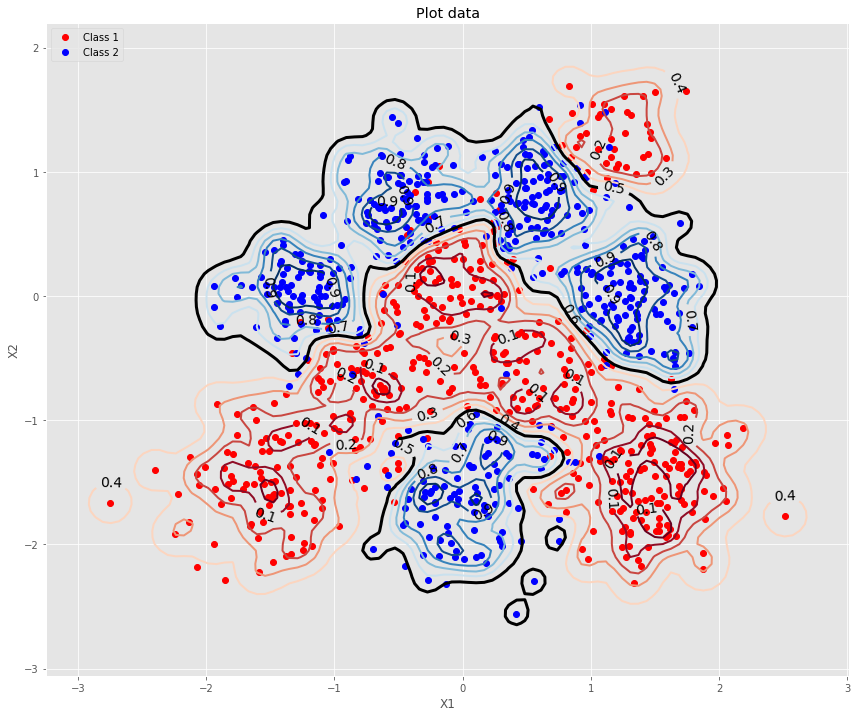

[[0.47  0.035]
 [0.075 0.42 ]]
Train ll:  -0.21671734997722608
Test ll:  -0.30744456643179247


In [48]:
X_train, X_test, y_train, y_test = split_data(X, y)

map_classifier(X_train, X_test, y_train, y_test, plot_dist=True, plot_size='big', cm=True, ll=True)

Bayesian: ...


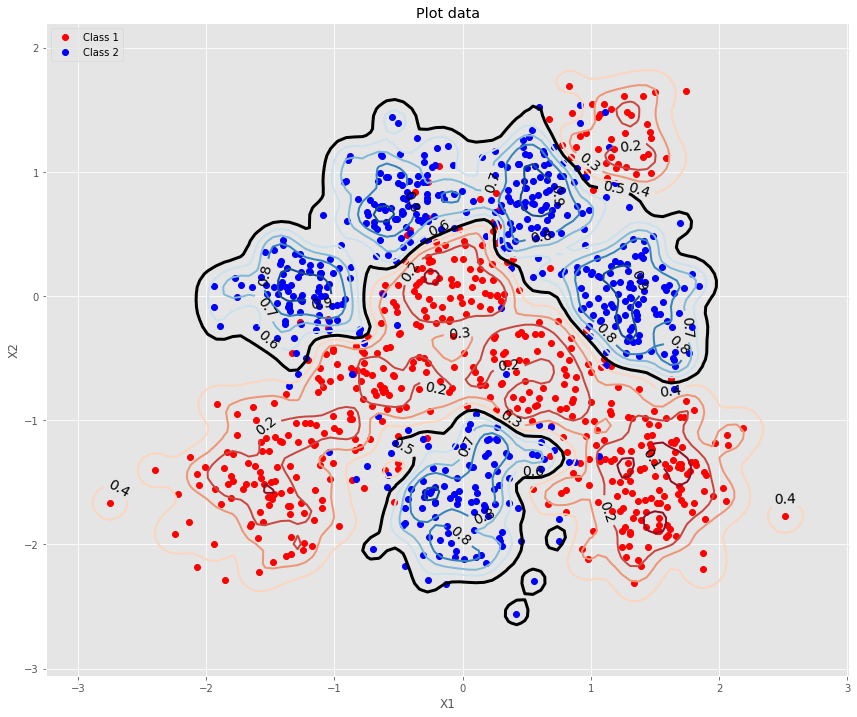

[[0.47  0.035]
 [0.075 0.42 ]]
Train ll:  -0.2725282807207757
Test ll:  -0.3424868432487759


In [49]:
vb_classifier(X_train, X_test, y_train, y_test, plot_dist=True, plot_size='big', cm=True, ll=True)

### Grid search function to optimize hyper-parameters:

In [60]:
import seaborn as sns

def bayes_hyperparam_tune(X_tr, l_min=-0.5, l_max=-0.35, sig_min=-0.01, sig_max=0.02, d=10):
    """
    - Function to perform a grid search over two hyper-parameters in order to find the best model
    - Model evidence as the objective function
    - Grid is dxd and the spacing is logarithmic
    - Prints gridpoint number every fifth gridpoint calculated as a way of indicating progress
    - Returns the settings of the model with the largest evidence, as well as the grid of evidences and the hyper-param ranges chosen
    """

    ls = np.logspace(l_min, l_max, d)[::-1]
    sigs = np.logspace(sig_min, sig_max, d)
    evidences = np.zeros((d, d))

    l_opt = 0
    sig_opt = 0
    log_Z_opt = -np.inf

    count = 0
    for i, l in enumerate(ls):
        X_tilde_train = get_x_tilde(evaluate_basis_functions(l, X_tr, X_tr))
        for j, sig in enumerate(sigs):
            log_Z = laplace_approx(X_tilde_train, y_train, sig)[2]
            evidences[i][j] = log_Z
            if log_Z > log_Z_opt:
                l_opt = l
                sig_opt = sig
                log_Z_opt = log_Z
            count += 1
            if not count % 5:
                print(count) # print the cell number of every 5th cell as a progress measure
    
    return l_opt, sig_opt, log_Z_opt, evidences, sigs, ls

### Show 10x10 grid as heatmap, show predictive distribution of best model

/tmp/ipykernel_1765/656362872.py:7: RuntimeWarning: divide by zero encountered in log
  ll = np.sum(y*np.log(preds) + (1-y)*np.log(1-preds))
/tmp/ipykernel_1765/656362872.py:7: RuntimeWarning: invalid value encountered in multiply
  ll = np.sum(y*np.log(preds) + (1-y)*np.log(1-preds))


5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
Optimal l:  0.3686945064519575
Optimal sigma:  1.0154689924330802
Optimal log_Z:  317.55784461351374
Bayesian: ...


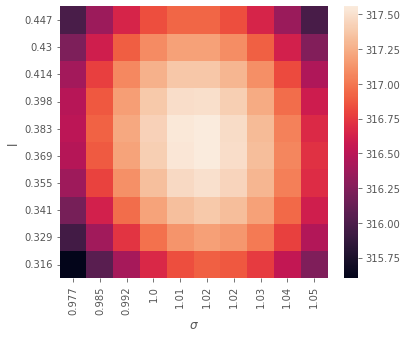

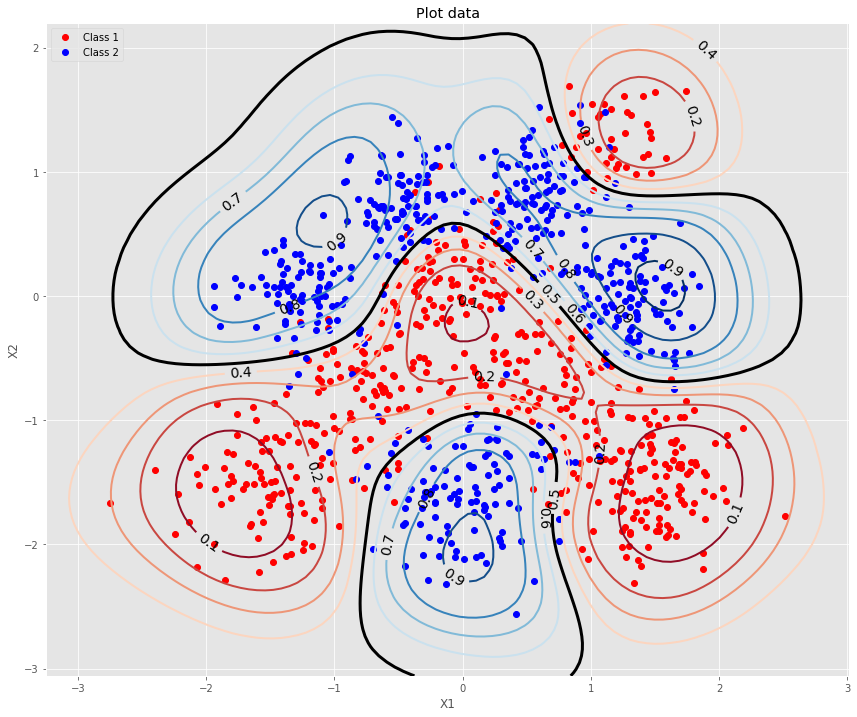

[[0.475 0.03 ]
 [0.05  0.445]]
Train ll:  -0.2794815776677867
Test ll:  -0.304960422445459


In [61]:
l_opt, sig_opt, log_Z_opt, evidences, sigs, ls = bayes_hyperparam_tune(X_train)

plt.rcParams['figure.figsize'] = [6, 5]
ax = plt.axes()
ax = sns.heatmap(evidences, xticklabels=[float('%.3g' % i) for i in sigs], yticklabels=[float('%.3g' % i) for i in ls], ax=ax)
ax.set_xlabel('$\sigma$')
ax.set_ylabel('l')
print('Optimal l: ', l_opt)
print('Optimal sigma: ', sig_opt)
print('Optimal log_Z: ', log_Z_opt)
vb_classifier(X_train, X_test, y_train, y_test, l=l_opt, sigma=sig_opt, plot_dist=True, plot_size='big', cm=True, ll=True)